# Customer Segmentation and Target Marketing Recommendations For CarMax
### A Notebook By Connor O'Brien


## Introduction

In this project, we'll analyze a dataset provided by CarMax for their [2021 CarMax Analytics Showcase](https://analyticsshowcase.carmax.com/). Below is the problem statement provided in the contest that we'll look to answer.


**Problem Statement: In today’s marketplace, customers expect and demand a personalized experience. Given historical industry sales, how can CarMax tailor its marketing and inventory strategies to draw in distinct segments of consumers?**

We'll start by dissecting each variable in the dataset, which contains a 'subset of nationwide used-car purchases for 2013, with vehicle purchase information, customer demographics, and post-purchase experience'. This will allow us to better understand the data and guide the discussion into the next section where we'll look for trends in that data that could help inform CarMax's marketing and inventory strategies. We'll wrap up by creating distinct clusters of purchasers that could be used for target marketing.

## 1. Data Exploration

Let's start by reading in the data and viewing the first 5 rows. 

In [1]:
# Imports
import itertools
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from sklearn import metrics 
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
##### Functions for this notebook

## Defining a function to compute the distribution of values for a single column in a dataframe.
# This will be used throughout this notebook to analyze various variables.
def analyze_col(df,col,full=False):
    # Returns the name, frequency, and rate (as a decimal)
    if full:
        # Creates a new df with the counts of each value
        counts = df[col].value_counts().reset_index(name='Frequency').rename(columns={'index': col})
        counts['Rate'] = counts['Frequency']/counts['Frequency'].sum()
        return counts
    # Returns the name and rate (as a percentage)
    else:
        # Creates a new df with the rate of each value
        df1 = df[col].value_counts()/df.insert_num.value_counts().sum()
        # Round each value so its a percentage and return df1
        return(df1.apply(lambda x: round(x*100,1)).reset_index())

# Function that turns categorical ranges into their average (with some exception cases)
def clean_price(s):
    if s =='?':
        return s
    elif s=='200001+':
        return '200'
    else:
        a,b = s.replace(' ','').split('-')
        if a=='0':
            return str(a)+'-'+str(b[:-3])
        else:
            return str(a[:-3])+'-'+str(b[:-3])    

# Defining a function to replace a range of value with it's average
def cell_avg(s):
    if s == '101+':
        return 101
    elif s == '200001+':
        return 200001
    else:
        a,b = s.replace(' ','').split('-')
        return int(int(b)*.5 + int(a)*.5)
    
# Creating a function to perform a statistical t-test 
def t_test(a,b):
    t, p = ttest_ind(a, b)
    if p<0.05:
        print('There is a statistically significant difference between the two population means.')
    else:
        print('There is not a statistically significant difference between the two population means.')

In [3]:
# Reading in the data
data = pd.read_csv('CaseCompetitionData2021.csv')
# Replacing ? with nan for easier manipulation
data = data.replace('?',np.NaN)
# Replacing the U in the gender column with nan
data.customer_gender = data.customer_gender.replace('U',np.NaN)
# Viewing the first 5 rows of the data
data.head(5)

,insert_num,purchase_make,purchase_model,purchase_vehicle_year,purchase_price,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases
0,81690,DODGE,CHARGER,2012,15001 - 20000,1,1,21 - 30,40001 - 60000,NaN,0,8,NaN,0,1
1,109994,FORD,F150,2007,15001 - 20000,0,0,51 - 60,0 - 20000,F,1,19,NaN,0,0
2,11399,BMW,328,2010,25001 - 30000,1,1,41 - 50,60001 - 80000,F,1,21,NaN,0,0
3,214156,LEXUS,GS 300,2003,10001 - 15000,0,1,21 - 30,20001 - 40000,M,0,8,NaN,0,0
4,36685,CHEVROLET,CRUZE,2012,15001 - 20000,1,1,31 - 40,120001 - 140000,M,1,5,NaN,1,1


Below is a table showing the amount of values missing for each variable (out of the 355874 rows) and the percentage of the data in that row that are missing. Of note is the 'post_purchase_satisfaction' variable that is missing 99.7% of its responses, as well as the 'customer_income' and 'customer_gender' that are missing 12.9% and 9.9% of their responses, respectively.

In [4]:
# Creating a new df with the number of missing values and percentage of missing values for each variable
missing_values_df = pd.concat([data.isnull().sum(),data.isnull().sum()/len(data)],axis=1) 
missing_values_df.rename(columns={0:'Missing Values',1:'% Missing'})

,Missing Values,% Missing
insert_num,0,0.000000
purchase_make,0,0.000000
purchase_model,0,0.000000
purchase_vehicle_year,0,0.000000
purchase_price,3,0.000008
trade_in,0,0.000000
vehicle_financing,0,0.000000
customer_age,1098,0.003085
customer_income,45998,0.129254
customer_gender,35268,0.099102


Let's now look at each variable individually and see if we can gain a deeper insight into CarMax's buyers and their behavior.

#### Purchase Makes and Purchase Models

The first two variables are the purchase makes and purchase models. 

There are 43 different purchase makes. The top ten manufacturers (shown below) make up 70% of all purchases.

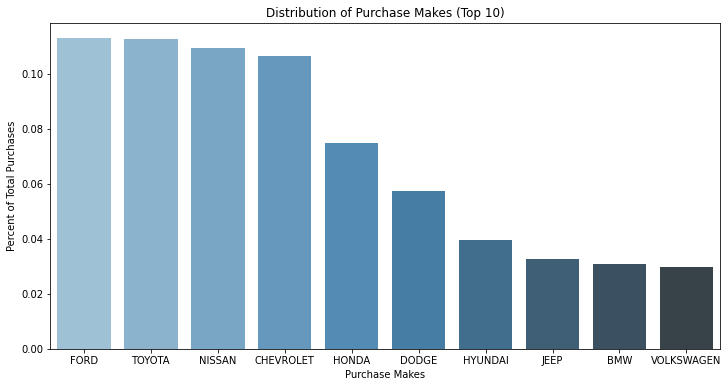

In [5]:
# Creating a dataset with the count and rate for each purchase make 
puchase_make_data = analyze_col(data,'purchase_make',True)
puchase_make_data = puchase_make_data.iloc[:10,:]

# Supressing a warning for the plot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting the distribution of purchase makes
plt.figure(figsize=(12,6)) # Setting the figure size
sns.barplot("purchase_make", y="Rate", data=puchase_make_data, palette="Blues_d")
plt.title("Distribution of Purchase Makes (Top 10)") # Setting the title
plt.xlabel("Purchase Makes") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label

Next, let's view a similar breakdown for the ten most common purchase models.

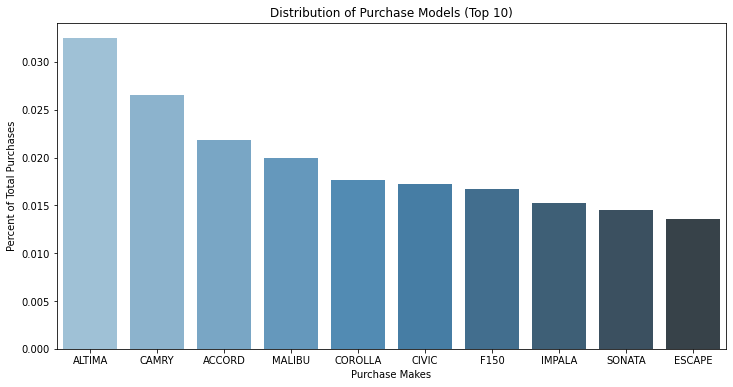

In [6]:
# Creating a dataset with the count and rate for each purchase model 
puchase_model_data = analyze_col(data,'purchase_model',True).head(10)
puchase_model_data.iloc[:10,:] = puchase_model_data

# Plotting the distribution of purchase models
plt.figure(figsize=(12,6)) # Setting the figure size
sns.barplot("purchase_model", y="Rate", data=puchase_model_data, palette="Blues_d")
plt.title("Distribution of Purchase Models (Top 10)") # Setting the title
plt.xlabel("Purchase Makes") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label

To understand which cars sell best, we'll need to group them by their year, make, and model. As shown below, the 2010 Nissan Altima was the most sold car in the data set, followed by the 2012 Nissan Altima and the 2012 Chevrolet Malibu.

In [7]:
# Making a new variable with a car's year, make, and model
year_make_model = data['purchase_vehicle_year'].astype(str) + ' ' + data['purchase_make'] + ' '+ data['purchase_model']
year_make_model = year_make_model.to_frame(name = 'year_make_model')

# Creating a dataset with the count and rate for each car 
year_make_model_data = analyze_col(year_make_model,'year_make_model',True).head(10)
# Viewing the 10 top selling cars
print('10 Best Selling Cars:')
year_make_model_data.head(10)

10 Best Selling Cars:


,year_make_model,Frequency,Rate
0,2010 NISSAN ALTIMA,3439,0.009664
1,2012 NISSAN ALTIMA,3231,0.009079
2,2012 CHEVROLET MALIBU,2950,0.008289
3,2011 TOYOTA CAMRY,2915,0.008191
4,2010 HONDA ACCORD,2727,0.007663
5,2011 HYUNDAI SONATA,2602,0.007312
6,2010 TOYOTA CAMRY,2387,0.006707
7,2012 FORD FOCUS,2228,0.006261
8,2010 TOYOTA COROLLA,2127,0.005977
9,2012 DODGE AVENGER,2110,0.005929


#### Purchase Vehicle Year

97% of purchase vehicle years were between 2004 and 2013, with 54% of purchase vehicle years sitting between 2010 and 2012.

The average 'model year age' at the time of purchase was 4.47 years.

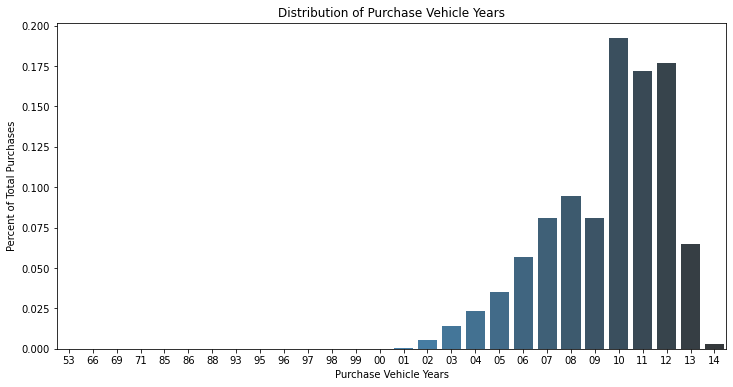

In [8]:
# Function to remove the first two characters to change years from XXXX to XX format plotting
def year_abrv(x):
    return str(x)[2:]

# Model year calculation used above
2014 - data.purchase_vehicle_year.mean(); #4.47

# Creating a dataset with the count and rate for each purchase year 
purchase_vehicle_year_data = analyze_col(data,'purchase_vehicle_year',True).sort_values(by=['purchase_vehicle_year'])
# Creating a new variable with smaller year labels for printing (e.x. 2005 -> 05)
purchase_vehicle_year_data['year_labels'] = purchase_vehicle_year_data['purchase_vehicle_year'].apply(year_abrv)

# Plotting the distribution of purchase vehicle years
plt.figure(figsize=(12,6)) # Setting the figure size
sns.barplot("year_labels", y="Rate", data=purchase_vehicle_year_data, palette="Blues_d")
plt.title("Distribution of Purchase Vehicle Years") # Setting the title
plt.xlabel("Purchase Vehicle Years") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label

#### Purchase Price

There are 18 unique groupings for the vehicle purchase price. Let's view them ordered by their frequency.

In [9]:
purchase_price_data = analyze_col(data,'purchase_price',True)
purchase_price_data

,purchase_price,Frequency,Rate
0,15001 - 20000,118204,0.332154
1,10001 - 15000,101178,0.284311
2,20001 - 25000,66341,0.186419
3,25001 - 30000,32330,0.090848
4,30001 - 35000,15265,0.042895
5,5001 - 10000,9110,0.025599
6,35001 - 40000,7271,0.020432
7,40001 - 45000,3061,0.008601
8,45001 - 50000,1575,0.004426
9,50001 - 55000,680,0.001911


80% of vehicles purchased were between \\$10,001 and $25,000, and 94% of vehicles purchased were between \\$5,000 and \\$35,000. 

Comparing this to the current public inventory on [carmax.com](https://www.carmax.com/), 92% of the the vehicles within 250 miles of my current zip code are priced between \\$6,000 - \\$35,000.

Let's view the overall distribution of purchases prices.

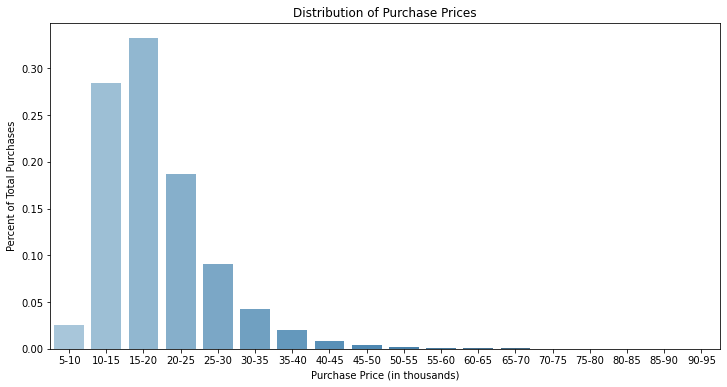

In [10]:
# Calculations used above
round(100*purchase_price_data.Rate[:5].sum(),2)# 93.66
round(100*purchase_price_data.Rate[:3].sum(),2);# 80.29

# Cleaning up the purchase price data for plotting
purchase_price_data.purchase_price = purchase_price_data.purchase_price.apply(clean_price)
nidx=[8,0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18]
purchase_price_data = purchase_price_data.sort_values(by='purchase_price').reset_index(drop=True).reindex(nidx).reset_index(drop=True)

# Plotting the distribution of purchase prices
plt.figure(figsize=(12,6)) # Setting the figure size
sns.barplot("purchase_price", y="Rate", data=purchase_price_data[:-1], palette="Blues_d")
plt.title("Distribution of Purchase Prices") # Setting the title
plt.xlabel("Purchase Price (in thousands)") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label

#### Trade-In

Next, let's see the percentage of purchases that included a trade-in.

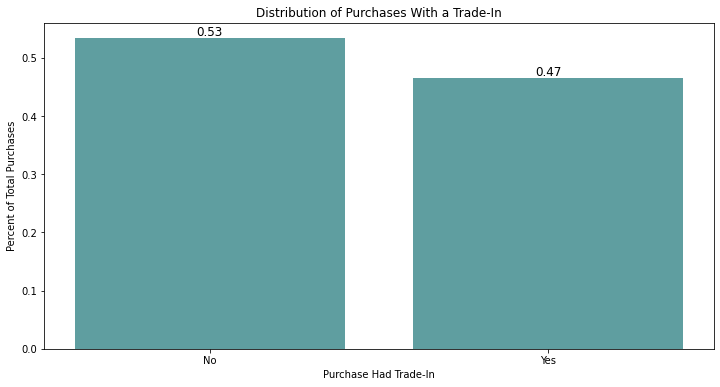

In [11]:
# Analyzing the trade in count and rate
trade_in_data = analyze_col(data,'trade_in',True)
# Cleaning up the data for plotting
trade_in_data.iloc[0,0] = 'No'
trade_in_data.iloc[1,0] = 'Yes'

# Plotting the distributoin of trade-in data
plt.figure(figsize=(12,6)) # Setting the figure size
plt.bar(trade_in_data.trade_in,trade_in_data.Rate, color="cadetblue")
plt.title("Distribution of Purchases With a Trade-In") # Setting the title
plt.xlabel("Purchase Had Trade-In") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label
no_value = trade_in_data.Rate.apply(lambda x: round(x,2))[0] # Creating bar labels
yes_value = trade_in_data.Rate.apply(lambda x: round(x,2))[1]
plt.text('No', no_value+.004, str(no_value),fontsize='large', ha = 'center', va='bottom', snap = False)
plt.text('Yes', yes_value-.005, str(yes_value),fontsize='large', ha = 'center', va='bottom', snap = False);  

#### Vehicle Financing

78% of transactions required a loan to finance their purchase, leaving the remaining 22% of purchasers to forgo financing.

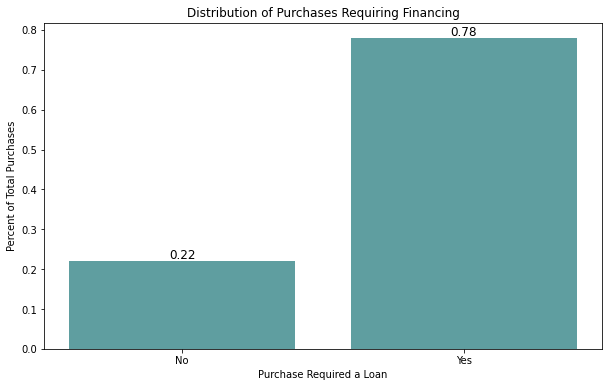

In [12]:
# Analyzing the vehicle finnacing data
vehicle_financing_data = analyze_col(data,'vehicle_financing',True)
vehicle_financing_data.iloc[0,0] = 'Yes'
vehicle_financing_data.iloc[1,0] = 'No'
# Plotting the distribution  of vehicle finance data
plt.figure(figsize=(10,6)) # Setting the figure size
plt.bar(vehicle_financing_data.vehicle_financing.iloc[::-1],vehicle_financing_data.Rate.iloc[::-1], color="cadetblue")
plt.title("Distribution of Purchases Requiring Financing") # Setting the title
plt.xlabel("Purchase Required a Loan") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label
# Setting up the y/n values for plotting
no_value = vehicle_financing_data.Rate.apply(lambda x: round(x,2))[1]
yes_value = vehicle_financing_data.Rate.apply(lambda x: round(x,2))[0]
plt.text('No', no_value, str(no_value),fontsize='large', ha = 'center', va='bottom', snap = False)
plt.text('Yes', yes_value-.001, str(yes_value),fontsize='large', ha = 'center', va='bottom', snap = False);

#### Customer Age Data

Let's look at the different customer age groups and the percentage of purchases that were made by that age group, ranked from most to least frequent. 87.58% of vehicles purchased were by buyers between the ages of 21 and 60.

In [13]:
customer_age_data = analyze_col(data,'customer_age',True)
customer_age_data

,customer_age,Frequency,Rate
0,31 - 40,88312,0.248923
1,41 - 50,84604,0.238472
2,21 - 30,83004,0.233962
3,51 - 60,54801,0.154466
4,61 - 70,26104,0.073579
5,71 - 80,8182,0.023062
6,0 - 20,6133,0.017287
7,81 - 90,2228,0.006280
8,101+,1251,0.003526
9,91 - 100,157,0.000443


Let's view the distribution of customer ages.

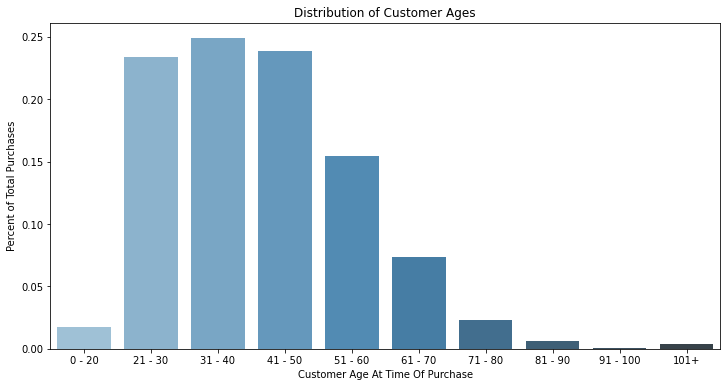

In [14]:
# Calculation used above
round(100*customer_age_data.Rate[:4].sum(),2) # 87.58

# Ordering by age bracket
nidx=[0,2,3,4,5,6,7,8,9,1,10]
customer_age_data = customer_age_data.sort_values(by='customer_age').reset_index(drop=True).reindex(nidx).reset_index(drop=True)

# Plotting the distribution of customer ages
plt.figure(figsize=(12,6)) # Setting the figure size
sns.barplot("customer_age", y="Rate", data=customer_age_data[:-1], palette="Blues_d")
plt.title("Distribution of Customer Ages") # Setting the title
plt.xlabel("Customer Age At Time Of Purchase") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label

#### Customer Income Data

Over half of purchases were made by customers with an income between \\$20,000 and \\$60,000, with 75% of all customers making less than \\$80,000. Lets view the distribution of purchases made by each customer income bracket.

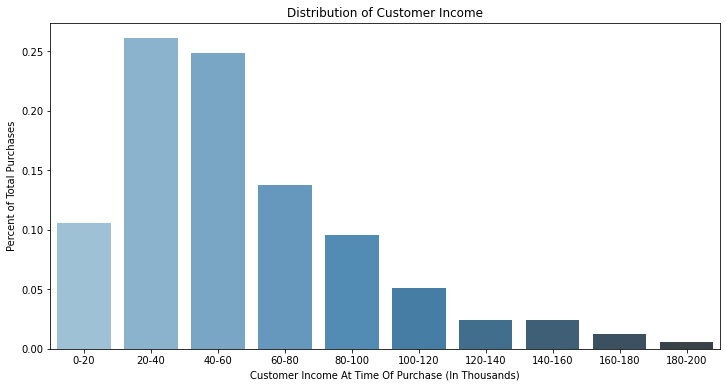

In [15]:
# Analyzing the count and rate of coustomer incomes
customer_income_data = analyze_col(data,'customer_income',True)
customer_income_data.head(2).Rate.sum() # .5094 - Calculation used above
customer_income_data.head(4).Rate.sum() # 0.7521s
# Cleaning the data for plotting 
customer_income_data.customer_income = customer_income_data.customer_income.apply(clean_price)
customer_income_data=customer_income_data.reindex([3,0,1,2,4,5,8,7,9,10,6]).reset_index(drop=True)
# Plotting the distribution of customer income
plt.figure(figsize=(12,6)) # Setting the figure size
sns.barplot("customer_income", y="Rate", data=customer_income_data[:-1], palette="Blues_d")
plt.title("Distribution of Customer Income") # Setting the title
plt.xlabel("Customer Income At Time Of Purchase (In Thousands)") # Setting the x-label
plt.ylabel("Percent of Total Purchases"); # Setting the y-label

#### Customer Gender

For the 91% of transactions that identified the customer's gender, 57.5% were made by men and 42.5% were made by women.

In [16]:
analyze_col(data,'customer_gender',True)

,customer_gender,Frequency,Rate
0,M,184500,0.575473
1,F,136106,0.424527


#### Customer Previous Purchases

20% of customers made a purchase prior to 2013 from the same dealer. Of those customers that made a previous purchase, 37% made a subsequent purchase after 2013 (alongside their 2013 purchase recorded in the data).

In [17]:
data_cpp = data[data.customer_previous_purchase !=0] # customers with previous purchase
data_cpp_sp = data_cpp[data_cpp.subsequent_purchases !=0] #previous purchase + subsequent purchase
len(data_cpp_sp)/len(data_cpp) # .371039233714372
analyze_col(data,'customer_previous_purchase',True)

,customer_previous_purchase,Frequency,Rate
0,0,283003,0.795234
1,1,72871,0.204766


#### Customer Distance to Dealer

95.73% of customers lived within 50 miles from the dealership at the time of purchase. Let's view the distribution of customer distances to the dealership at the time of purchase in 2013.

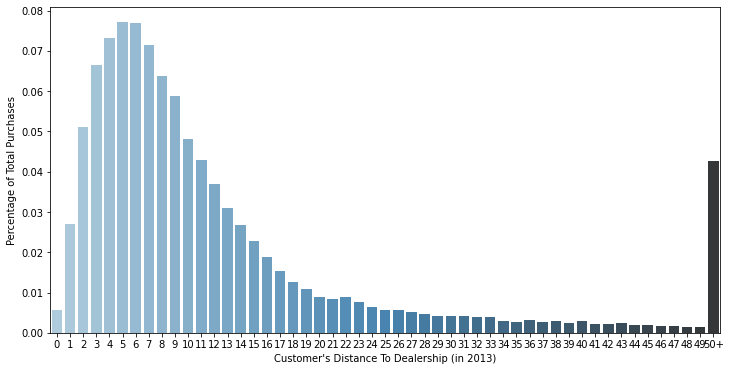

In [18]:
# Analyzing the rate and distribution of 'customer_distance_to_dealer'
data_customer_distance_to_dealer = analyze_col(data,'customer_distance_to_dealer',True)

# Calculations used above
data_customer_distance_to_dealer=data_customer_distance_to_dealer.dropna(subset=['customer_distance_to_dealer']) # Remove missing values
data_customer_distance_to_dealer.customer_distance_to_dealer= data_customer_distance_to_dealer.customer_distance_to_dealer.astype(int) # converting to int
data_customer_distance_to_dealer = data_customer_distance_to_dealer.sort_values(by='customer_distance_to_dealer').reset_index(drop=True) # sorting by distance
round(100*data_customer_distance_to_dealer.head(50).Rate.sum(),2); # 95.7 - Finding % within 50 miles

# Combining all distances above 49 for easier plotting
fiftyplus_Rate = data_customer_distance_to_dealer[50:].Rate.sum()
fiftyplus_Freq = data_customer_distance_to_dealer[50:].Frequency.sum()
data_customer_distance_to_dealer.iloc[50] = ['50+',fiftyplus_Freq,fiftyplus_Rate]
data_customer_distance_to_dealer = data_customer_distance_to_dealer.head(51)

# Plotting the distribution of customer distances
plt.figure(figsize=(12,6)) # Setting the figure size
sns.barplot(data=data_customer_distance_to_dealer,x='customer_distance_to_dealer',y='Rate', palette="Blues_d")
plt.xlabel("Customer's Distance To Dealership (in 2013)") # Setting the x-label
plt.ylabel("Percentage of Total Purchases"); # Setting the y-label

#### Post Purchase Satisfaction

As discussed earlier, customers responded to the post-purchase satisfaction survey in only 0.3% of purchases. Because of this, we'll leave it out for the majority of the subsequent analyses. 

Let's see how the customer post-purchase satisfaction responses that were recorded break down.

In [19]:
analyze_col(data,'post_purchase_satisfaction',True).reindex([0,1,2,3,5,4,7,8,9,6]).reset_index(drop=True)

,post_purchase_satisfaction,Frequency,Rate
0,10,803,0.670284
1,9,221,0.184474
2,8,92,0.076795
3,7,34,0.028381
4,6,12,0.010017
5,0,12,0.010017
6,4,6,0.005008
7,3,5,0.004174
8,1,1,0.000835
9,5,12,0.010017


#### Vehicle Warranty Used

25% of purchases leveraged the dealer's vehicle warranty. Later, we'll look at what trends were present in purchases where the vehicle warranty was (and wasn't) purchased. 

In [20]:
analyze_col(data,'vehicle_warranty_used',True)

,vehicle_warranty_used,Frequency,Rate
0,0,266158,0.7479
1,1,89716,0.2521


#### Subsequent Purchase

Finally, let's look at the data for the amount of subsequent purchases made by each customer. 

33.67% of customers made a subsequent purchase after 2013. Of the customers that made subsequent purchases, 80.62% made just 1 subsequent purchase in the following five years (2014-2018).

In [21]:
# Analyzing the distribution of subsequent purchases
data_subsequent_purchases=analyze_col(data,'subsequent_purchases',True)

# Calculatios used above
100 - round(100*data_subsequent_purchases.iloc[0,2],2) # = 33.67 - included subsequent purchase
without_subsequent_purchase = analyze_col(data[data.subsequent_purchases!=0],'subsequent_purchases',True) # including only cases w/subsequent purchase
round(100*without_subsequent_purchase.iloc[0,2],2); # 80.62 - one subsequent purchase/count all subsq

# Viewing the distribution of subsequent purchases
data_subsequent_purchases.reindex([0,1,2,3,4,5,8,6,9,7,10]).reset_index(drop=True)

,subsequent_purchases,Frequency,Rate
0,0,236056,0.663313
1,1,96594,0.271428
2,2,9256,0.026009
3,3,3698,0.010391
4,4,3103,0.008719
5,5,1989,0.005589
6,6,1051,0.002953
7,7,1073,0.003015
8,8,1008,0.002832
9,9,1069,0.003004


### Correlations

Before stepping into the analysis, let's create a correlation 'heatmap' that shows how dependent each pair of variables are.

In [22]:
# Function to return the average of a range of numbers
def avg_two(s):
    if s=='200001+':
        return 200001
    elif s=='101+':
        return 101
    else:
        a,b = s.replace(' ','').split('-')
        if a==np.NaN:
            return np.NaN
        else:
            return int(a)/2+int(b)/2

# Creating and plotting a correlation heatmap 
corr_data = data.copy()
corr_data = corr_data.dropna(subset=['purchase_price','customer_income','customer_age'])
corr_data.purchase_price = corr_data.purchase_price.apply(avg_two)
corr_data.customer_income = corr_data.customer_income.apply(avg_two)
corr_data.customer_age = corr_data.customer_age.apply(avg_two)

A few findings include:

* The purchase price is moderately correlated to the purchase income.
* Whether a trade-in was present is moderately correlated to the purchase price.
* The purchase vehicle year isn't strongly correlated with whether the vehicle warranty was used.
* The customer previous purchase isn't strongly correlated with whether they financed their vehicle purchase.

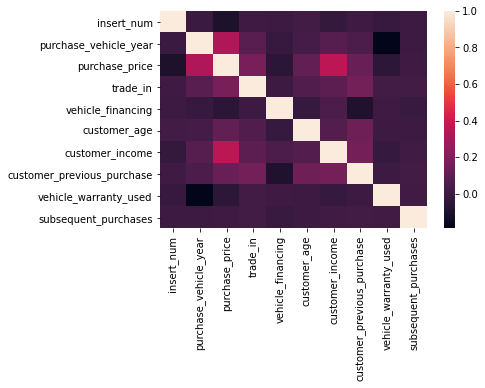

In [23]:
sns.heatmap(corr_data.corr());

## 2. Analyses and Prediction

In this section, we'll use several approaches to segment CarMax customers into distinct groups, as well as build  models to predict the purchase behavior of current and potential customers.

A focus for this section is to identify trends in variables we deem 'high value' for the business, allowing CarMax to make informed marketing and inventory decisions that leverages their industry knowledge. For example, the buyers that are more likely to make subsequent purchase may not be the same buyers that finance their vehicle. Our goal is to provide CarMax with guidance and insights into their buyers' behavior to better inform their strategy decisions.

### Finding Repeat Customers

An important variable in the dataset is whether the purchaser made a subsequent purchase. Repeat customers have a high customer lifetime value, making them valuable to the firm. As shown above, 34% of the purchases involved customers who made a subsequent purchase following their 2013 purchase.

Let's explore the data and see if there are certain demographics of buyers that are more likely to have made subsequent purchases. Understanding these trends could help CarMax focus its marketing and inventory strategies to better attract customers with a high lifetime value.

Before doing so, let's create a new variable, 'made_subsequent_purchase', to denote if a subsequent purchase was made.

In [24]:
data['made_subsequent_purchase'] = data['subsequent_purchases'].map({0:0,1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1})
data.head(5)

,insert_num,purchase_make,purchase_model,purchase_vehicle_year,purchase_price,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases,made_subsequent_purchase
0,81690,DODGE,CHARGER,2012,15001 - 20000,1,1,21 - 30,40001 - 60000,NaN,0,8,NaN,0,1,1
1,109994,FORD,F150,2007,15001 - 20000,0,0,51 - 60,0 - 20000,F,1,19,NaN,0,0,0
2,11399,BMW,328,2010,25001 - 30000,1,1,41 - 50,60001 - 80000,F,1,21,NaN,0,0,0
3,214156,LEXUS,GS 300,2003,10001 - 15000,0,1,21 - 30,20001 - 40000,M,0,8,NaN,0,0,0
4,36685,CHEVROLET,CRUZE,2012,15001 - 20000,1,1,31 - 40,120001 - 140000,M,1,5,NaN,1,1,1


#### Relationship Between 'customer_gender' and 'made_subsequent_purchase' 

Let's look at the relationship between gender and subsequent purchases.

In [25]:
# Customer gender
msp_mean = round(100*data.made_subsequent_purchase.mean(),2)
print('Overall percentage of subsequent purchases: '+ str(msp_mean) +'%.')
print('Male percentage of subsequent purchases: '+ str(round(100*data[data.customer_gender == 'M'].made_subsequent_purchase.mean(),2)) +'%.')
print('Female percentage of subsequent purchases: '+ str(round(100*data[data.customer_gender == 'F'].made_subsequent_purchase.mean(),2)) +'%.')
print('Men are ' + str(round(100*(34.19-33.06)/33.06,2)) + '% more likely to have made subsequent purchases.')

Overall percentage of subsequent purchases: 33.67%.
Male percentage of subsequent purchases: 34.19%.
Female percentage of subsequent purchases: 33.06%.
Men are 3.42% more likely to have made subsequent purchases.


#### Relationship Between 'customer_income' and 'made_subsequent_purchase' 

Next, let's see if a customer's income is related to whether they made a subsequent purchase. 

In [26]:
#  Getting unique customer incomes
income_list = list(data.customer_income.unique())
income_mspp = []
# Getting subsequent purchase percentage for each income
for i in income_list:
    income_mspp.append(str(round(data[data.customer_income == i].made_subsequent_purchase.mean(),2)))
# Adding the income brackets and subsequent purchase made percentages to a dataframe    
income_v_mspp = pd.DataFrame(list(zip(income_list, income_mspp)), 
            columns =['customer_income', 'made_subsequent_purchase_percentage']).append({'customer_income': 'All','made_subsequent_purchase_percentage':str(round(msp_mean/100,2))}, ignore_index=True).sort_values(by = 'made_subsequent_purchase_percentage', ascending = False).dropna().reset_index(drop=True)
income_v_mspp

,customer_income,made_subsequent_purchase_percentage
0,200001+,0.4
1,160001 - 180000,0.38
2,140001 - 160000,0.37
3,120001 - 140000,0.36
4,80001 - 100000,0.35
5,100001 - 120000,0.35
6,180001 - 200000,0.35
7,All,0.34
8,40001 - 60000,0.33
9,0 - 20000,0.33


Customers with an income above \\$80,000 were more likely than average to have made a subsequent purchase, while those making below \\$80,000 were less likely than average to make a subsequent purchase.

#### Relationship Between 'customer_age' and 'made_subsequent_purchase' 

Overall, age wasn't highly correlated with whether a subsequent purchase was made. The only two age brackets with significant differences were 101+ and 0-20, both of which were above the average for all ages groups.

In [27]:
age_list = list(data.customer_age.unique())
age_mspp = []
for a in age_list:
    age_mspp.append(str(round(data[data.customer_age == a].made_subsequent_purchase.mean(),2)))
age_v_mspp = pd.DataFrame(list(zip(age_list, age_mspp)), 
            columns =['customer_age', 'made_subsequent_purchase_percentage']).append({'customer_age': 'All','made_subsequent_purchase_percentage':str(round(msp_mean/100,2))}, ignore_index=True).sort_values(by = 'made_subsequent_purchase_percentage', ascending = False).dropna().reset_index(drop=True)
age_v_mspp

,customer_age,made_subsequent_purchase_percentage
0,101+,0.43
1,0 - 20,0.36
2,51 - 60,0.34
3,41 - 50,0.34
4,All,0.34
5,21 - 30,0.33
6,31 - 40,0.33
7,61 - 70,0.33
8,81 - 90,0.33
9,71 - 80,0.32


#### Relationship Between 'trade_in', 'vehicle_warranty_used', and 'made_subsequent_purchase' 

Customers that traded in a vehicle at the time of their purchase were 14% more likely to have made a subsequent purchase than customers that didn't trade in a vehicle, and customers that leveraged the dealer's vehicle warranty were 9% more likely to make a subsequent purchase than customers that did not.

In [28]:
# Trade in v made_subsequent_purchase
tradein_n = data[data.trade_in ==0].made_subsequent_purchase.mean()
tradein_y = data[data.trade_in == 1].made_subsequent_purchase.mean()
(tradein_y-tradein_n)/tradein_n # 0.1360240660515319

# Trade in v  vehicle_warranty_used
vwu_n = data[data. vehicle_warranty_used ==0].made_subsequent_purchase.mean()
vwu_y = data[data. vehicle_warranty_used == 1].made_subsequent_purchase.mean()
(vwu_y-vwu_n)/vwu_n; # 0.08938566251581653

#### Customer Previous Purchase Recommendation

Below is a summary regarding which segments of buyers were more or less likely to have made a subsequent purchase.

* There was little difference between the subsequent buying behavior of men and women, with men 3.42% more likely to have made a subsequent purchase than women.
* A customer's income is related to whether they made a subsequent purchase, with customers earning above \\$80,000 making more than the average amount of subsequent purchases, and those below \\$80,000 making below the average amount of subsequent purchases.
* The customer's age showed a small correlation with whether they make a subsequent purchase, with all age brackets below 100 sitting within 2 percentage points of the overall average amount of subsequent purchases made. 
* Customers that either traded in a vehicle at the time of purchase or leveraged the dealer's warranty were more likely to have made a subsequent purchase.

### Subsequent Purchase Made v Year/Make/Model

Continuing the discussion from above, grouping whether a subsequent purchase was made by each make, year, and model car yields some interesting results. 

To start, let's make a dataset with the 3030 unique cars sold, along with the amount of subsequent purchases made by customers that bought that unique car. We'll also include the number of each type of car sold to filter our results by. 

In [29]:
# Creating a new column with the year/make/model
data['year_make_model'] = data['purchase_vehicle_year'].astype(str) + ' ' + data['purchase_make'] + ' ' + data['purchase_model']
# Counting how many of each car was sold
data['model_count'] = data.groupby('year_make_model')['year_make_model'].transform('count')
# Similar code as earlier.
p_prices = list(data.year_make_model.unique())
fr_list = []
for p in p_prices:
    fr_list.append(str(round(data[data.year_make_model == p].made_subsequent_purchase.mean(),2)))
ppf_df = pd.DataFrame(list(zip(p_prices, fr_list)), 
            columns =['purchase_model', 'made_subsequent_purchase_percentage']).append({'purchase_model': 'All','made_subsequent_purchase_percentage':str(round(data.made_subsequent_purchase.mean(),2))}, ignore_index=True).sort_values(by = 'made_subsequent_purchase_percentage', ascending = False).dropna().reset_index(drop=True)
# Merging the made_subsequent_purchase_percentage data with the model count data
model_sp = ppf_df.merge(data[['year_make_model','model_count']], left_on = 'purchase_model', right_on = 'year_make_model').drop_duplicates(subset=['year_make_model'])
model_sp = model_sp[['year_make_model','made_subsequent_purchase_percentage','model_count']].reset_index(drop=True)

If we look at the cars with the highest 'made_subsequent_purchase_percentage', we'll see outliers where only a few of that car were sold. Its safe to say that stocking up on 1988 Porsche 911s probably isn't the best inventory strategy.

In [30]:
model_sp.head(10)

,year_make_model,made_subsequent_purchase_percentage,model_count
0,1988 PORSCHE 911,1.0,2
1,2001 FORD F350,1.0,2
2,2006 MAZDA B2300,1.0,3
3,2003 VOLVO S80,1.0,1
4,2006 JAGUAR XJ8,1.0,2
5,2003 LAND ROVER RANGE ROVER,1.0,1
6,2006 CHEVROLET EXPRESS 1500,1.0,4
7,2000 MERCEDES-BENZ S500,1.0,1
8,2012 MERCEDES-BENZ ML550,1.0,2
9,2005 GMC SAVANA 2500,1.0,1


Instead, let's filter by models sold over 1000 times. Below are top 5 and bottom 5 models from the 45 that meet this critera.

In [31]:
# Top 5 models above 1000 sales
model_sp[model_sp.model_count > 1000].head(5)

,year_make_model,made_subsequent_purchase_percentage,model_count
1386,2012 FORD MUSTANG,0.36,1053
1594,2012 FORD FOCUS,0.35,2228
1600,2010 FORD F150,0.35,1151
1605,2011 FORD EDGE,0.35,1377
1729,2012 FORD ESCAPE,0.34,1174


In [33]:
# Bottom 5 models above 1000 sales
model_sp[model_sp.model_count > 1000].tail(5)

,year_make_model,made_subsequent_purchase_percentage,model_count
2357,2012 NISSAN SENTRA,0.31,1225
2360,2011 TOYOTA CAMRY,0.31,2915
2376,2011 CHEVROLET AVEO,0.31,1159
2424,2010 HONDA ACCORD,0.31,2727
2477,2011 NISSAN ALTIMA,0.31,1574


The standout here is all five models that resulted in the highest percentage of subsequent purchases were Fords. 

With a dataset this size, we expect there to be randomness and for some vehicles to outperform the overall average of 33.67% for the subsequent purchases made percentage. However, there may be value in knowing that Fords consistently outperform other brands in achieving subsequent purchases. 

For example, the Ford F-150 model consistently outperformed the average in terms of resulting in subsequent purchases.

In [34]:
model_sp[model_sp['year_make_model'].str.contains("FORD F150")].append({'year_make_model': 'All','made_subsequent_purchase_percentage':str(round(data.made_subsequent_purchase.mean(),2)), 'model_count':len(data)}, ignore_index=True).sort_values(by = 'made_subsequent_purchase_percentage', ascending = False).dropna().reset_index(drop=True)

,year_make_model,made_subsequent_purchase_percentage,model_count
0,2001 FORD F150,0.5,2
1,2012 FORD F150,0.4,774
2,2011 FORD F150,0.37,828
3,2009 FORD F150,0.36,435
4,2013 FORD F150,0.36,412
5,2007 FORD F150,0.36,633
6,2010 FORD F150,0.35,1151
7,2005 FORD F150,0.35,268
8,2008 FORD F150,0.34,620
9,2004 FORD F150,0.34,162


This analysis could be readily extended to asses other models and manufacturers, as well as factors such as a car's manufacturing date, body style, or mileage. Further, we could also incorporate other responses, such as if the purchase leveraged a warranty or financing from CarMax.

### Trends With Vehicle Financing

Next, let's see if there are any variables related to whether a person required a loan to finance their vehicle purchase. 

#### Relationship Between 'customer_income' and 'vehicle_financing'

First, let's view the relationship between a customer's income and whether they financed their purchase.

If we focus only on purchases where the customer's income was listed, the average finance usage rate was 89%. Let's see the finance usage rate for each income bracket.

In [35]:
data_ci = data.dropna(subset=['customer_income'])
ci_list = list(data_ci.customer_income.unique())
fu_list = []
for c in ci_list:
    fu_list.append(str(round(data_ci[data_ci.customer_income == c].vehicle_financing.mean(),2)))
fu_list
ci_v_fu = pd.DataFrame(list(zip(ci_list, fu_list)), 
            columns =['customer_income', 'financing_usage']).append({'customer_income': 'All','financing_usage':str(round(data_ci.vehicle_financing.mean(),2))}, ignore_index=True).sort_values(by = 'financing_usage', ascending = False).dropna().reset_index(drop=True)
ci_v_fu

,customer_income,financing_usage
0,40001 - 60000,0.91
1,20001 - 40000,0.91
2,60001 - 80000,0.9
3,80001 - 100000,0.9
4,140001 - 160000,0.9
5,100001 - 120000,0.9
6,120001 - 140000,0.89
7,180001 - 200000,0.89
8,160001 - 180000,0.89
9,All,0.89


The majority of customer income brackets are grouped together at a financing usage rate around 90%. There isn't a large difference among the customer income brackets, except for the income bracket between \\$0 and \\$20,000 that had a much lower finance usage rate of 73%.

You may notice there is a large discrepency in the average financing usage rate for purchases when rows where the customer's income are missing are removed (78% v 89%). This reveals that purchases without the income listed are much less likely to finance their purchase. We believe this missing data trend warrants further investigation.

#### Relationship Between 'customer_gender' and 'vehicle_financing'

Next, let's see how gender relates to whether a purchaser needed to finance their purchase. 

In [36]:
# Customer gender
print('Overall need for financing: '+ str(round(100*data.vehicle_financing.mean(),2)) +'%.')
print('Male need for financing: '+ str(round(100*data[data.customer_gender == 'M'].vehicle_financing.mean(),2)) +'%.')
print('Female need for financing: '+ str(round(100*data[data.customer_gender == 'F'].vehicle_financing.mean(),2)) +'%.')
print('Females were ' + str(round(100*(80.01-76.11)/76.11,2)) + '% more likely to use financing.')

Overall need for financing: 77.93%.
Male need for financing: 76.11%.
Female need for financing: 80.01%.
Females were 5.12% more likely to use financing.


#### Relationship Between 'customer_age' and 'vehicle_financing' 

Let's see how finance usage relates to a purchaser's age bracket.

In [37]:
ca_list = list(data_ci.customer_age.unique())
fr_list = []
for c in ca_list:
    fr_list.append(str(round(data[data.customer_age == c].vehicle_financing.mean(),2)))
fr_list
ppf_df = pd.DataFrame(list(zip(ca_list, fr_list)), 
            columns =['customer_age', 'financing_usage']).append({'customer_age': 'All','financing_usage':str(round(data.vehicle_financing.mean(),2))}, ignore_index=True).sort_values(by = 'financing_usage', ascending = False).dropna().reset_index(drop=True)
ppf_df

,customer_age,financing_usage
0,21 - 30,0.82
1,31 - 40,0.82
2,41 - 50,0.78
3,All,0.78
4,0 - 20,0.75
5,51 - 60,0.74
6,61 - 70,0.68
7,101+,0.6
8,71 - 80,0.6
9,81 - 90,0.46


The age brackets between 21-50 all sit above the average finance usage rate of 78%. The remaining age brackets all have a finance usage rate below 78%, with each bracket above 71 years old sitting at 60% or lower. 

#### Relationship Between 'trade_in' and 'vehicle_financing' 

As shown below, there is little difference between vehicle financing rates when a purchaser traded in their vehicle.

In [38]:
p_prices = list(data.trade_in.unique())
fr_list = []
for p in p_prices:
    fr_list.append(str(round(data[data.trade_in == p].vehicle_financing.mean(),2)))
fr_list
ppf_df = pd.DataFrame(list(zip(p_prices, fr_list)), 
            columns =['trade_in', 'financing_usage']).append({'trade_in': 'All','financing_usage':str(round(data.vehicle_financing.mean(),2))}, ignore_index=True).sort_values(by = 'financing_usage', ascending = False).dropna().reset_index(drop=True)
ppf_df

,trade_in,financing_usage
0,1,0.79
1,All,0.78
2,0,0.77


#### Vehicle Financing Analysis Summary

Below is a summary regarding which segments of buyers were more likely to have financed their vehicle.

* A customer's income showed little correlation with whether they financed a vehicle, save the '\\$0 - \\$20,000' income bracket that financed at a considerably lower rate.
* Women were 5% more likely to use financing than men.
* Buyers between the ages of 21 and 50 used financing at above average rates, while buyers above 70 used financing at below average rates.
* Whether a customer traded in a vehicle had little effect on if they financed their vehicle.
* Purchasers whose income wasn't listed were much less likely to have financed their purchase.

### Warranty Usage Trends

Next, let's better understand what types of customers utilize the vehicle warranty and on what types of vehicles they were used.

First, we'll create a modified version of the original dataset optimized for this analysis.

In [39]:
# Creating an optimized dataset for this section
data_w = data.drop(['insert_num','post_purchase_satisfaction'],axis=1).dropna(subset = ['customer_distance_to_dealer','customer_age','customer_income','customer_gender','purchase_price'])

Shown below are the average for several variable responses, along with their averages when the warranty was and wasn't used.

#### Purchase Vehicle Year v Warranty Used

In [40]:
print('Average Purchase Vehicle Year: ' + str(round(data.purchase_vehicle_year.mean(),2)))
print('Average Purchase Vehicle Year (warranty used): ' + str(round(data[data.vehicle_warranty_used == 1].purchase_vehicle_year.mean(),2)))
print('Average Purchase Vehicle Year (warranty not used): ' + str(round(data[data.vehicle_warranty_used == 0].purchase_vehicle_year.mean(),2)))
t_test(data[data.vehicle_warranty_used == 0].purchase_vehicle_year,data[data.vehicle_warranty_used == 1].purchase_vehicle_year)

Average Purchase Vehicle Year: 2009.53
Average Purchase Vehicle Year (warranty used): 2008.72
Average Purchase Vehicle Year (warranty not used): 2009.8
There is a statistically significant difference between the two population means.


#### Purchase Price v Warranty Used

In [41]:
print('Average Purchase Price: $' + str(int(round(data_w.purchase_price.apply(cell_avg).mean()))))
print('Average Purchase Price (warranty used): $' + str(int(round(data_w[data_w.vehicle_warranty_used == 1].purchase_price.apply(cell_avg).mean()))))
print('Average Purchase Price (warranty not used): $' + str(int(round(data_w[data_w.vehicle_warranty_used == 0].purchase_price.apply(cell_avg).mean()))))
t_test(data_w[data_w.vehicle_warranty_used == 0].purchase_price.apply(cell_avg),data_w[data_w.vehicle_warranty_used == 1].purchase_price.apply(cell_avg))

Average Purchase Price: $19144
Average Purchase Price (warranty used): $18519
Average Purchase Price (warranty not used): $19360
There is a statistically significant difference between the two population means.


#### Customer Income v Warranty Used

In [42]:
print('Average Customer Income : $' + str(int(round(data_w.customer_income.apply(cell_avg).mean()))))
print('Average Customer Income (warranty used): $' + str(int(round(data_w[data_w.vehicle_warranty_used == 1].customer_income.apply(cell_avg).mean()))))
print('Average Customer Income (warranty not used): $' + str(int(round(data_w[data_w.vehicle_warranty_used == 0].customer_income.apply(cell_avg).mean()))))
t_test(data_w[data_w.vehicle_warranty_used == 0].customer_income.apply(cell_avg),data_w[data_w.vehicle_warranty_used == 1].customer_income.apply(cell_avg))

Average Customer Income : $62932
Average Customer Income (warranty used): $61353
Average Customer Income (warranty not used): $63477
There is a statistically significant difference between the two population means.


#### Customer Age v Warranty Used

In [43]:
print('Average Customer Age : ' + str(round(data_w.customer_age.apply(cell_avg).mean(),2)))
print('Average Customer Age (warranty used) : ' + str(round(data_w[data_w.vehicle_warranty_used == 1].customer_age.apply(cell_avg).mean(),2)))
print('Average Customer Age (warranty not used): ' + str(round(data_w[data_w.vehicle_warranty_used == 0].customer_age.apply(cell_avg).mean(),2)))
t_test(data_w[data_w.vehicle_warranty_used == 0].customer_age.apply(cell_avg),data_w[data_w.vehicle_warranty_used == 1].customer_age.apply(cell_avg))

Average Customer Age : 40.92
Average Customer Age (warranty used) : 41.0
Average Customer Age (warranty not used): 40.89
There is not a statistically significant difference between the two population means.


#### Warranty Usage Summary

Warranties were more likely to be used on older vehicles with a lower purchase price, and by customers with a lower income. These trends aren't drastic, but they are statistically significant relationships in the data.

### Predicting a Customer's Purchase Price

The next question we'd like to answer is: Can we predict a customer's purchase price based on their income, age, and gender?

The short answer: yes, but not very accurately.

The reason for this is we have too little demographic data to predict on with a large range of predictions, namely, the purchase price categories. For example, the most common purchase price for buyers between the ages of 41-50 is \\$15,001-\\$20,000, though it only accounts for 33% of the purchases for this age group. However, this doesn't mean building a model to predict a customer's purchase price is trivial, as it can provide marketers with a reasonable start point when estimating a buyer's purchase price.

Let's build such a model and discuss the findings below. We'll start by trimming the dataset to focus in on the purchase price, customer age, customer income, and customer gender for each transaction.

#### Cleaning The Data

To prepare the data for analysis, it'll be easier if the ranges of values are represented by a single integer. We'll set each value range to the average of those two values, and any single value used in a category to that same value (the corresponding range-value pairs can be found in the appendix.) 

For example, ages 51-60 will be replaced by 55, and the income range \\$15,001-\\$20,000 will be replaced by \\$17,500.

Below are the first five rows of the cleaned data set.

In [44]:
data_sv = data.drop(['insert_num','post_purchase_satisfaction','purchase_make','purchase_model'],axis=1)
data_sv = data_sv.dropna(subset = ['customer_distance_to_dealer','customer_age','customer_income','customer_gender','purchase_price'])
data_sv.customer_distance_to_dealer = data_sv.customer_distance_to_dealer.astype(int)
data_sv.customer_gender = data_sv.customer_gender.map({'F':0,'M':1})
data_sv['purchase_price'] = data_sv['purchase_price'].apply(cell_avg)
data_sv['customer_age'] = data_sv['customer_age'].apply(cell_avg)
data_sv['customer_income'] = data_sv['customer_income'].apply(cell_avg)
data_slim = data_sv[['purchase_price','customer_age','customer_income','customer_gender']]
data_slim.head(5)

,purchase_price,customer_age,customer_income,customer_gender
1,17500,55,10000,0
2,27500,45,70000,0
3,12500,25,30000,1
4,17500,35,130000,1
6,22500,25,30000,1


Next, we'll build a classification model to predict (i.e. classify) what a customer's purchase price will be based off their age, income, and gender. We'll do so using a technique called [Naive Bayes Classification](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# Creating the training and response datasets
X = data_slim[['customer_age','customer_income','customer_gender']]
y = data_slim[['purchase_price']].values.ravel()

# Creating training/testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Creating the Naive Bayes MOdel
cnb = CategoricalNB()

# Training the model 
cnb.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = cnb.predict(X_test)

# Accuracy
print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred))

Model Accuracy: 0.3634958816240251


As shown above, the accuracy for this model is 36%. This performance isn't great, but as mentioned above, it could provide a starting point for marketers and salespeople when predicting a customer's purchase price. Further, this model could be improved with additional information about a customer, such as their profession, the value of their trade-in, and the value of any previous purchases.

Let's apply this model to a few subsets of the possible combinations for age, income, and gender. There are 220 combinations with the categories given in the data set.  

In [47]:
# Creating list of all possible combinations of age, income, and gender
age_income_gender_iters = list(itertools.product(list(data_slim.customer_age.unique()), list(data_slim.customer_income.unique()),list(data_slim.customer_gender.unique())))
age_income_gender_iters = [i for i in age_income_gender_iters if np.nan not in i]
# Finding how many combinations there are
len(age_income_gender_iters); # 220
# Choosing 3 combinations and predicting on them
age_income_gender_iters[36] #(45, 50000, 0)
cnb.predict(np.asarray(age_income_gender_iters[36]).reshape(1, -1))[0]  # 17500
age_income_gender_iters[45] #(25, 10000, 1)
cnb.predict(np.asarray(age_income_gender_iters[45]).reshape(1, -1))[0] # 12500
age_income_gender_iters[8] # (55, 90000, 0)
cnb.predict(np.asarray(age_income_gender_iters[8]).reshape(1, -1))[0]; # 17500
print('Three Model Recommendations:')
print('')
print('Age: 41-49  Income: $40,001 - $60,000   Gender: Female | Predicted Purchase Price: 15001 - 20000')
print('Age: 21-29  Income: $0 - $20,000        Gender: Male   | Predicted Purchase Price: 10001 - 15000' )
print('Age: 51-59  Income: $80,001 - $100,000  Gender: Female | Predicted Purchase Price: 15001 - 20000' )
print('')

Three Model Recommendations:

Age: 41-49  Income: $40,001 - $60,000   Gender: Female | Predicted Purchase Price: 15001 - 20000
Age: 21-29  Income: $0 - $20,000        Gender: Male   | Predicted Purchase Price: 10001 - 15000
Age: 51-59  Income: $80,001 - $100,000  Gender: Female | Predicted Purchase Price: 15001 - 20000




For all but one combination, the recommended purchase price is between 10,001 and 20,000, with around half the recommendations split between the 10,000 - 15,000 and 15,001 - 20,000 ranges. 

A similar approach could be used to recommend a year/make/model to a customer based on their income, age, and gender. This model won't be highly 'accurate' due to the large number of possible car recommendations, but it could improved with additional demographic data, as well as a customer's car preferences (body style, price range, etc.).

Let's build such a model and see what it recommends for the three individuals above. First, we'll create a new dataset optimized for training the model.

In [48]:
# New dataset with the cars year/make/model
data_pm = data.drop(['insert_num','post_purchase_satisfaction'],axis=1)
data_pm = data_pm.dropna(subset = ['customer_distance_to_dealer','customer_age','customer_income','customer_gender','purchase_price'])
data_pm.customer_distance_to_dealer = data_pm.customer_distance_to_dealer.astype(int)
data_pm.customer_gender = data_pm.customer_gender.map({'F':0,'M':1})
# Limiting to 2010+ models to reduce memory cost for building this model (~46% of the data)
data_pm = data_pm[data_pm.purchase_vehicle_year  > 2008].reset_index(drop=True)
data_pm['purchase_price'] = data_pm['purchase_price'].apply(cell_avg)
data_pm['customer_age'] = data_pm['customer_age'].apply(cell_avg)
data_pm['customer_income'] = data_pm['customer_income'].apply(cell_avg)
data_pm['year_make_model'] = data_pm['purchase_vehicle_year'].astype(str) + ' ' + data_pm['purchase_make'] + ' ' + data_pm['purchase_model'] 
data_pm_slim = data_pm[['year_make_model','customer_income','customer_age','customer_gender','purchase_price']]

We'll then use a Naive Bayes classifier to predict the car's year/make/model from the customer's age, income, gender, and purchase price.

In [49]:
# Creating the training and response datasets
X = data_pm_slim[['customer_age','customer_income','customer_gender','purchase_price']]
y = data_pm_slim[['year_make_model']].values.ravel()

# Creating the Naive Bayes MOdel
cnb2 = CategoricalNB()

# Training the model 
cnb2.fit(X, y)

# Predict the response for test dataset
y_pred = cnb2.predict(X)

Below are examples of three vehicle recommendations.

In [50]:
print('Model Recommendations:')
print('')
print('Age: 41-49  Income: $40,001 - $60,000   Gender: Female  Purchase Price: 15001 - 20000 | Suggested car: '+ cnb2.predict(np.array([45,50000,0,17500]).reshape(1, -1))[0])
print('')
print('Age: 21-29  Income: $0 - $20,000        Gender: Male    Purchase Price: 10001 - 15000 | Suggested car: '+ cnb2.predict(np.array([25,1000,1,12500]).reshape(1, -1))[0])
print('')
print('Age: 51-59  Income: $80,001 - $100,000  Gender: Female  Purchase Price: 15001 - 20000 | Suggested car: '+ cnb2.predict(np.array([55,90000,0,17500]).reshape(1, -1))[0])

Model Recommendations:

Age: 41-49  Income: $40,001 - $60,000   Gender: Female  Purchase Price: 15001 - 20000 | Suggested car: 2010 NISSAN ALTIMA

Age: 21-29  Income: $0 - $20,000        Gender: Male    Purchase Price: 10001 - 15000 | Suggested car: 2012 CHEVROLET MALIBU

Age: 51-59  Income: $80,001 - $100,000  Gender: Female  Purchase Price: 15001 - 20000 | Suggested car: 2010 NISSAN ALTIMA


## 3. Creating Consumer Segments

In this section, we'll create distinct groups of purchases using a technique called [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). The k-means clustering algorithm will create k clusters of purchases that are most similar to one another. This approach doesn't provide the model with any 'labels' to predict for; rather, it will group the data on variables it deems important (i.e. that help segment the data).

First, we'll copy the original dataset and optimize it for clustering.

In [51]:
# Scaling the data
data_scaled  = data[['purchase_price','trade_in','vehicle_financing','customer_age','customer_income','customer_gender','customer_previous_purchase','customer_distance_to_dealer','vehicle_warranty_used','subsequent_purchases']]
data_scaled = data_scaled.dropna(subset = ['customer_distance_to_dealer','customer_age','customer_income','customer_gender','purchase_price'])
data_scaled['customer_income'] = data_scaled['customer_income'].apply(cell_avg)
data_scaled['customer_age'] = data_scaled['customer_age'].apply(cell_avg)
data_scaled['purchase_price'] = data_scaled['purchase_price'].apply(cell_avg)
data_scaled.customer_gender = data_scaled.customer_gender.map({'F':0,'M':1})
ds_cols = data_scaled.columns

scaler = StandardScaler()
scaler.fit(data_scaled)
data_scaled = scaler.transform(data_scaled)
data_scaled =pd.DataFrame(data_scaled, columns = ds_cols)

Next, we need to determine how many clusters we'd like to use. We'll use a clustering technique called the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to determine the 'right' number of clusters. To implement this, we'll run the k-means algorithm with cluster sizes between 3 and 14, looking for when there are 'diminishing returns' in the amount of similarity across clusters. 

This technique is called the elbow method because when you plot the number of clusters against the [sum of squared distances of samples to their closest cluster center](https://discuss.analyticsvidhya.com/t/what-is-within-cluster-sum-of-squares-by-cluster-in-k-means/2706), the 'elbow' in the graph is a good hueristic for how many clusters to use.

In [52]:
km_scores = []
for i in range(3,15): # Looping through different k values and appendidng their 'inertia' (wcss) to a list
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data_scaled)
    km_scores.append(kmeans.inertia_)

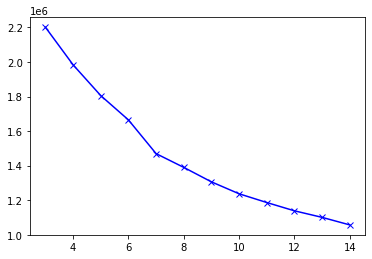

In [53]:
plt.plot(range(3,15),km_scores, 'bx-') # Plotting the looped k-values against their k-means wcss

According to the plot above, 7 appears to be a reasonable value for the number of clusters (though we could easily use more or less)

With the number of clusters decided, let's fit our final k-means clustering model.

In [54]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(data_scaled);

With the model built, let's see what clusters it assigned to each data point. The rightmost column, labeled 'Cluster', now contains the cluster (0 through 6) assigned by the k-means algorithm.

In [55]:
data_clustered = pd.DataFrame(scaler.inverse_transform(data_scaled), columns = ds_cols).assign(Cluster =kmeans.labels_ )
data_clustered.customer_previous_purchase = data_clustered.customer_previous_purchase.round()
data_clustered

,purchase_price,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,Cluster
0,17500.0,0.0,0.0,55.0,10000.0,0.0,1.0,19.0,0.0,0.0,6
1,27500.0,1.0,1.0,45.0,70000.0,0.0,1.0,21.0,0.0,0.0,4
2,12500.0,0.0,1.0,25.0,30000.0,1.0,0.0,8.0,0.0,0.0,2
3,17500.0,1.0,1.0,35.0,130000.0,1.0,1.0,5.0,1.0,1.0,4
4,22500.0,0.0,1.0,25.0,30000.0,1.0,0.0,8.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
274374,22500.0,1.0,1.0,55.0,50000.0,0.0,1.0,3.0,0.0,0.0,4
274375,37500.0,0.0,1.0,45.0,110000.0,1.0,0.0,14.0,0.0,4.0,3
274376,17500.0,0.0,1.0,25.0,30000.0,0.0,0.0,13.0,0.0,0.0,2
274377,17500.0,1.0,1.0,65.0,30000.0,0.0,1.0,9.0,0.0,1.0,4


Let's analyze each cluster and see on which characteristics the clusters were seperated. 

Below are the mean values for the responses in each cluster, along with the overall means to compare with. 

In [56]:
data_clustered.groupby('Cluster').mean().append(pd.Series(data_clustered.groupby('Cluster').mean().mean(), name ='All'))

,purchase_price,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases
Cluster,,,,,,,,,,
0,18501.859386,1.000000,1.000000,40.070307,51102.192621,0.512896,0.000000,13.571458,0.000000,0.511994
1,17066.480883,0.445989,1.000000,39.753573,50482.749452,0.520700,0.000043,12.561992,1.000000,0.531457
2,16919.826498,0.000000,1.000000,38.857736,48636.555085,0.534707,0.000000,14.954344,0.000000,0.485277
3,29819.426436,0.608306,0.962245,44.838266,157549.360346,0.810655,0.302570,13.308405,0.190298,0.554801
4,19065.391061,0.617731,1.000000,43.992952,65280.642869,0.573793,1.000000,13.009825,0.266454,0.548128
5,20448.207171,0.569721,0.828685,34.302789,63386.478088,0.641434,0.187251,2045.195219,0.274900,0.529880
6,19728.648863,0.469262,0.000000,41.442292,52554.554964,0.614985,0.325952,14.197283,0.253570,0.570135
All,20221.405757,0.530144,0.827276,40.465416,69856.076204,0.601310,0.259402,303.828361,0.283603,0.533096


For an example, let's dissect the first cluster, Cluster 0. 

* The average 'purchase_price' is \\$29,940, nearly 50\% heigher than the overall average. 
* The 'trade_in' and 'vehicle_financing' rated are both slightly above average.
* The average 'customer_income' is \\$153,374, which is over double the overall average.
* The 'customer_gender' is 80% male.
* The 'customer_previous_purchase' is around the average at 28%.
* The 'customer_distance_to_dealer' is similar to most other clusters at 13.
* The 'vehicle_warranty_used' was below average at 18%.
* The amount of 'subsequent_purchases' was around the average at 0.55.

With the clustering applied, we now have seven distinct segments of purchases grouped along different variables. CarMax could use these cluster assignments to provide each segment a unique marketing mix. For example, Cluster 0 could be enrolled in a post-purchase flow tailored to that cluster's demographics, such as their high average income and purchase price. As mentioned earlier, we could easily adjust the number of clusters to better fit a specific marketing or sales strategy.

To employ this clustering, we could segment new purchasers into one of the seven pre-defined clusters and provide them with a rigorous post-purchase marketing flow that incorporates variables important to that segment.

## Summary and Suggestions

In this notebook, we were able to gain a deeper understanding into CarMax's used car sales and their customers. We were able to find several factors that correlated with 'high-value' variables that could be leveraged by marketers and inventory strategists. We also built several models to predict the purchase price and purchase make and model for different demographics of consumers, as well created distinct segments of purchases that could be used for target marketing.

### Appendix

Below are the 'coded' representations for the purchase price, customer age, and customer income used in thie project.

In [57]:
purchase_price_coded = pd.DataFrame(data.purchase_price.unique(), columns = ['purchase_price']).dropna().sort_values(by='purchase_price')
purchase_price_coded['purchase_price_coded'] = list(sorted(list(data_sv.purchase_price.unique())))
purchase_price_coded

,purchase_price,purchase_price_coded
2,10001 - 15000,7500
0,15001 - 20000,12500
3,20001 - 25000,17500
1,25001 - 30000,22500
5,30001 - 35000,27500
4,35001 - 40000,32500
7,40001 - 45000,37500
8,45001 - 50000,42500
9,50001 - 55000,47500
6,5001 - 10000,52500


In [58]:
customer_age_coded = pd.DataFrame(data.customer_age.unique(), columns = ['customer_age']).dropna().reindex([5,0,3,2,1,4,8,6,10,7]).reset_index(drop=True)
customer_age_coded['customer_age_coded'] = list(sorted(list(data_sv.customer_age.unique())))
customer_age_coded

,customer_age,customer_age_coded
0,0 - 20,10
1,21 - 30,25
2,31 - 40,35
3,41 - 50,45
4,51 - 60,55
5,61 - 70,65
6,71 - 80,75
7,81 - 90,85
8,91 - 100,95
9,101+,101


In [59]:
customer_income_coded = pd.DataFrame(data.customer_income.unique(), columns = ['customer_income']).dropna().reindex([1,3,0,2,5,8,4,6,11,10,9]).reset_index(drop=True)
customer_income_coded['customer_income_coded'] = list(sorted(list(data_sv.customer_income.unique())))
customer_income_coded

,customer_income,customer_income_coded
0,0 - 20000,10000
1,20001 - 40000,30000
2,40001 - 60000,50000
3,60001 - 80000,70000
4,80001 - 100000,90000
5,100001 - 120000,110000
6,120001 - 140000,130000
7,140001 - 160000,150000
8,160001 - 180000,170000
9,180001 - 200000,190000
